### Assignment - 1

#### 1. Load and Inspect the CMAPSS Dataset
Task:
- Write Python code to load the raw `train_FD001.txt` dataset for CMAPSS using Pandas, assign appropriate column names, and display the shape, data types, and first 5 rows of the DataFrame.
- Expected Output: DataFrame shape, info, and sample rows.

Use the link to download the dataset:
https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

print(os.listdir('/content/drive/MyDrive/CMAPSS_Dataset'))


['train_FD001.txt']


In [6]:
import pandas as pd

# Define the path to your file
file_path = '/content/drive/MyDrive/CMAPSS_Dataset/train_FD001.txt'

# Define column names (based on NASA dataset format)
col_names = (
    ['unit_number', 'time_cycles',
     'setting_1', 'setting_2', 'setting_3'] +
    [f'sensor_{i}' for i in range(1, 22)]
)

# Read the dataset
df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)


<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2238943207.py:14: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)


In [7]:
# Display basic info
print("✅ Dataset loaded successfully!\n")
print("Shape:", df.shape)

✅ Dataset loaded successfully!

Shape: (20631, 26)


In [5]:
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 Rows:\n", df.head())


Data Types:
 unit_number      int64
time_cycles      int64
setting_1      float64
setting_2      float64
setting_3      float64
sensor_1       float64
sensor_2       float64
sensor_3       float64
sensor_4       float64
sensor_5       float64
sensor_6       float64
sensor_7       float64
sensor_8       float64
sensor_9       float64
sensor_10      float64
sensor_11      float64
sensor_12      float64
sensor_13      float64
sensor_14      float64
sensor_15      float64
sensor_16      float64
sensor_17        int64
sensor_18        int64
sensor_19      float64
sensor_20      float64
sensor_21      float64
dtype: object

First 5 Rows:
    unit_number  time_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1            1    -0.0007    -0.0004      100.0    518.67   
1            1            2     0.0019    -0.0003      100.0    518.67   
2            1            3    -0.0043     0.0003      100.0    518.67   
3            1            4     0.0007     0.0000      100.0  

In [10]:
import matplotlib.pyplot as plt

#### 2. Visualize Sensor Distributions and Identify Missing Values
Task:
- Using the loaded dataset (or the cleaned version), visualize the distribution of values for any three sensor columns with histograms, and check for missing values in all columns.
- Expected Output: Three histogram plots and a summary/report on missing values per column.

In [9]:
# Check missing values
missing_values = df.isnull().sum()

print("Missing Values per Column:\n")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")


Missing Values per Column:

No missing values found


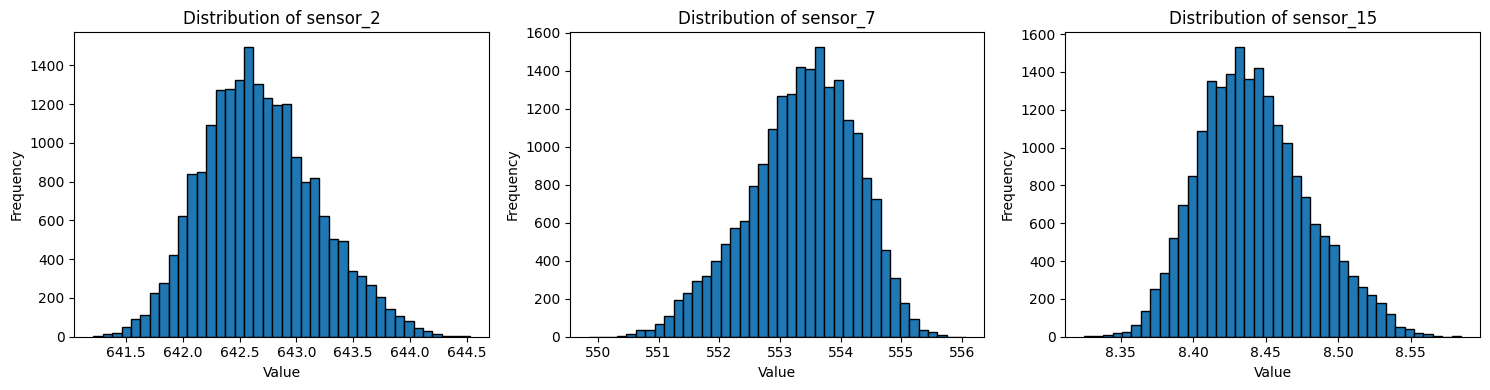

In [11]:
# Select three sensor columns
sensor_cols = ['sensor_2', 'sensor_7', 'sensor_15']

# Plot histograms
plt.figure(figsize=(15, 4))

for i, col in enumerate(sensor_cols, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=40, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### 3. Feature Engineering – Aggregation and Rolling Statistics
Task:
- For a selected sensor (e.g., `sensor_2`), compute and append to the DataFrame:
  - The mean and standard deviation of `sensor_2` by each `engine_id`

  - The rolling mean (window size=5) for each engine’s `sensor_2` readings
- Expected Output: Show a few sample rows with these new features.

In [12]:
# Compute mean and std for sensor_2 by each engine
sensor_stats = df.groupby('unit_number')['sensor_2'].agg(['mean', 'std']).reset_index()
sensor_stats.rename(columns={'mean': 'sensor_2_mean', 'std': 'sensor_2_std'}, inplace=True)

# Merge back to main DataFrame
df = df.merge(sensor_stats, on='unit_number', how='left')


In [13]:
# Sort by engine and time before applying rolling window
df = df.sort_values(by=['unit_number', 'time_cycles'])

# Apply rolling mean per engine
df['sensor_2_roll_mean_5'] = (
    df.groupby('unit_number')['sensor_2']
      .rolling(window=5, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)


In [14]:
# Display key columns for inspection
sample_cols = ['unit_number', 'time_cycles', 'sensor_2',
               'sensor_2_mean', 'sensor_2_std', 'sensor_2_roll_mean_5']

print(df[sample_cols].head(10))

   unit_number  time_cycles  sensor_2  sensor_2_mean  sensor_2_std  \
0            1            1    641.82     642.621042      0.486795   
1            1            2    642.15     642.621042      0.486795   
2            1            3    642.35     642.621042      0.486795   
3            1            4    642.35     642.621042      0.486795   
4            1            5    642.37     642.621042      0.486795   
5            1            6    642.10     642.621042      0.486795   
6            1            7    642.48     642.621042      0.486795   
7            1            8    642.56     642.621042      0.486795   
8            1            9    642.12     642.621042      0.486795   
9            1           10    641.71     642.621042      0.486795   

   sensor_2_roll_mean_5  
0            641.820000  
1            641.985000  
2            642.106667  
3            642.167500  
4            642.208000  
5            642.264000  
6            642.330000  
7            642.3720

#### 4. Data Normalization
Task:
- Normalize all sensor columns in the DataFrame using `StandardScaler` from `scikit-learn` (zero mean, unit variance) and create a new DataFrame, maintaining the original `engine_id` and `cycle` columns.
- Expected Output: Head of the normalized DataFrame and a check that means are close to zero, std are close to one.

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
# Identify sensor columns
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform sensor columns
scaled_data = scaler.fit_transform(df[sensor_cols])

# Create a new DataFrame with normalized sensor values
normalized_df = pd.DataFrame(scaled_data, columns=sensor_cols)

# Add back engine_id and time_cycles columns
normalized_df.insert(0, 'time_cycles', df['time_cycles'])
normalized_df.insert(0, 'unit_number', df['unit_number'])


In [17]:
print("Normalization Completed!\n")
print("Head of Normalized DataFrame:")
print(normalized_df.head())


Normalization Completed!

Head of Normalized DataFrame:
   unit_number  time_cycles  sensor_1  sensor_2  sensor_3  sensor_4  \
0            1            1       0.0 -1.721725 -0.134255 -0.925936   
1            1            2       0.0 -1.061780  0.211528 -0.643726   
2            1            3       0.0 -0.661813 -0.413166 -0.525953   
3            1            4       0.0 -0.661813 -1.261314 -0.784831   
4            1            5       0.0 -0.621816 -1.251528 -0.301518   

       sensor_5  sensor_6  sensor_7  sensor_8  ...  sensor_12  sensor_13  \
0 -1.776357e-15  0.141683  1.121141 -0.516338  ...   0.334262  -1.058890   
1 -1.776357e-15  0.141683  0.431930 -0.798093  ...   1.174899  -0.363646   
2 -1.776357e-15  0.141683  1.008155 -0.234584  ...   1.364721  -0.919841   
3 -1.776357e-15  0.141683  1.222827  0.188048  ...   1.961302  -0.224597   
4 -1.776357e-15  0.141683  0.714393 -0.516338  ...   1.052871  -0.780793   

   sensor_14  sensor_15     sensor_16  sensor_17  sensor_18 

In [18]:
means = normalized_df[sensor_cols].mean().round(4)
stds = normalized_df[sensor_cols].std().round(4)

print("\n Mean of each sensor column (should be ~0):\n", means)
print("\n Std of each sensor column (should be ~1):\n", stds)



 Mean of each sensor column (should be ~0):
 sensor_1     0.0
sensor_2     0.0
sensor_3    -0.0
sensor_4     0.0
sensor_5    -0.0
sensor_6    -0.0
sensor_7    -0.0
sensor_8     0.0
sensor_9    -0.0
sensor_10    0.0
sensor_11   -0.0
sensor_12   -0.0
sensor_13    0.0
sensor_14    0.0
sensor_15   -0.0
sensor_16   -0.0
sensor_17    0.0
sensor_18    0.0
sensor_19    0.0
sensor_20    0.0
sensor_21    0.0
dtype: float64

 Std of each sensor column (should be ~1):
 sensor_1     0.0
sensor_2     1.0
sensor_3     1.0
sensor_4     1.0
sensor_5     0.0
sensor_6     1.0
sensor_7     1.0
sensor_8     1.0
sensor_9     1.0
sensor_10    0.0
sensor_11    1.0
sensor_12    1.0
sensor_13    1.0
sensor_14    1.0
sensor_15    1.0
sensor_16    0.0
sensor_17    1.0
sensor_18    0.0
sensor_19    0.0
sensor_20    1.0
sensor_21    1.0
dtype: float64


#### 5. Rolling Window Sequence Generation
Task:
- Write a function to generate rolling window sequences of length 30 for the sensors of each engine. Save the resulting 3D NumPy array (num_sequences, window_size, num_features), and save the corresponding engine_id and cycle identifier lists as CSV files. Print the shape of the resulting sequence array and contents of the first entry.
- Expected Output: Array shape, example content, and confirmation of successful file saves.

In [19]:
import numpy as np
import pandas as pd


In [20]:
def generate_sequences(df, sensor_cols, window_size=30):
    """
    Generates rolling window sequences for each engine.

    Parameters:
        df: DataFrame with columns ['unit_number', 'time_cycles', sensor_1 ... sensor_n]
        sensor_cols: list of sensor columns to include
        window_size: length of rolling window

    Returns:
        sequences: 3D NumPy array (num_sequences, window_size, num_features)
        engine_ids: list of engine IDs corresponding to each sequence
        cycle_ids: list of cycle numbers corresponding to the last time step of each sequence
    """
    sequences = []
    engine_ids = []
    cycle_ids = []

    for engine_id, group in df.groupby('unit_number'):
        group = group.sort_values('time_cycles')
        data = group[sensor_cols].values
        num_cycles = data.shape[0]

        for i in range(num_cycles - window_size + 1):
            seq = data[i:i+window_size]
            sequences.append(seq)
            engine_ids.append(engine_id)
            cycle_ids.append(group['time_cycles'].values[i + window_size - 1])

    sequences = np.array(sequences)
    return sequences, engine_ids, cycle_ids


In [21]:
# Use the normalized DataFrame from Step 4
window_size = 30
sequences, engine_ids, cycle_ids = generate_sequences(normalized_df, sensor_cols, window_size)

print("✅ Sequences Generated Successfully!")
print("Shape of sequences array:", sequences.shape)
print("\nExample first sequence:\n", sequences[0])
print("\nCorresponding Engine ID:", engine_ids[0], "Cycle:", cycle_ids[0])


✅ Sequences Generated Successfully!
Shape of sequences array: (17731, 30, 21)

Example first sequence:
 [[ 0.00000000e+00 -1.72172539e+00 -1.34255176e-01 -9.25935964e-01
  -1.77635684e-15  1.41683329e-01  1.12114057e+00 -5.16338406e-01
  -8.62813315e-01  0.00000000e+00 -2.66466596e-01  3.34261840e-01
  -1.05889024e+00 -2.69071040e-01 -6.03815700e-01 -1.38777878e-17
  -7.81709786e-01  0.00000000e+00  0.00000000e+00  1.34849274e+00
   1.19442705e+00]
 [ 0.00000000e+00 -1.06177971e+00  2.11528494e-01 -6.43725866e-01
  -1.77635684e-15  1.41683329e-01  4.31930175e-01 -7.98092999e-01
  -9.58817615e-01  0.00000000e+00 -1.91582925e-01  1.17489932e+00
  -3.63645998e-01 -6.42844737e-01 -2.75851811e-01 -1.38777878e-17
  -7.81709786e-01  0.00000000e+00  0.00000000e+00  1.01652793e+00
   1.23692196e+00]
 [ 0.00000000e+00 -6.61812625e-01 -4.13165589e-01 -5.25953148e-01
  -1.77635684e-15  1.41683329e-01  1.00815526e+00 -2.34583813e-01
  -5.57139248e-01  0.00000000e+00 -1.01530330e+00  1.36472069e+00


In [22]:
# Convert lists to DataFrame
ids_df = pd.DataFrame({'unit_number': engine_ids, 'time_cycles': cycle_ids})

# Save to CSV files
ids_df.to_csv('/content/drive/MyDrive/CMAPSS_Dataset/sequence_ids.csv', index=False)
np.save('/content/drive/MyDrive/CMAPSS_Dataset/sequences.npy', sequences)

print("\n Sequence array saved as 'sequences.npy'")
print(" Engine ID and cycle CSV saved as 'sequence_ids.csv'")



 Sequence array saved as 'sequences.npy'
 Engine ID and cycle CSV saved as 'sequence_ids.csv'
